In [1]:
import torch 
import torch.nn as nn

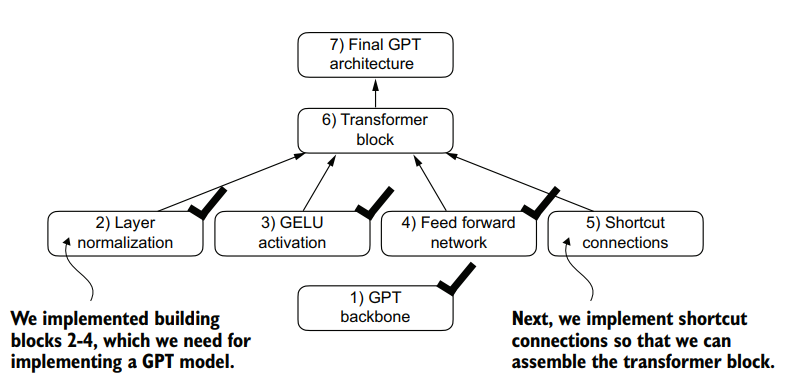

Originally, shortcut connections were proposed for deep networks in
computer vision (specifically, in residual networks) to mitigate the challenge of vanishing gradients

An illustration is as follows:

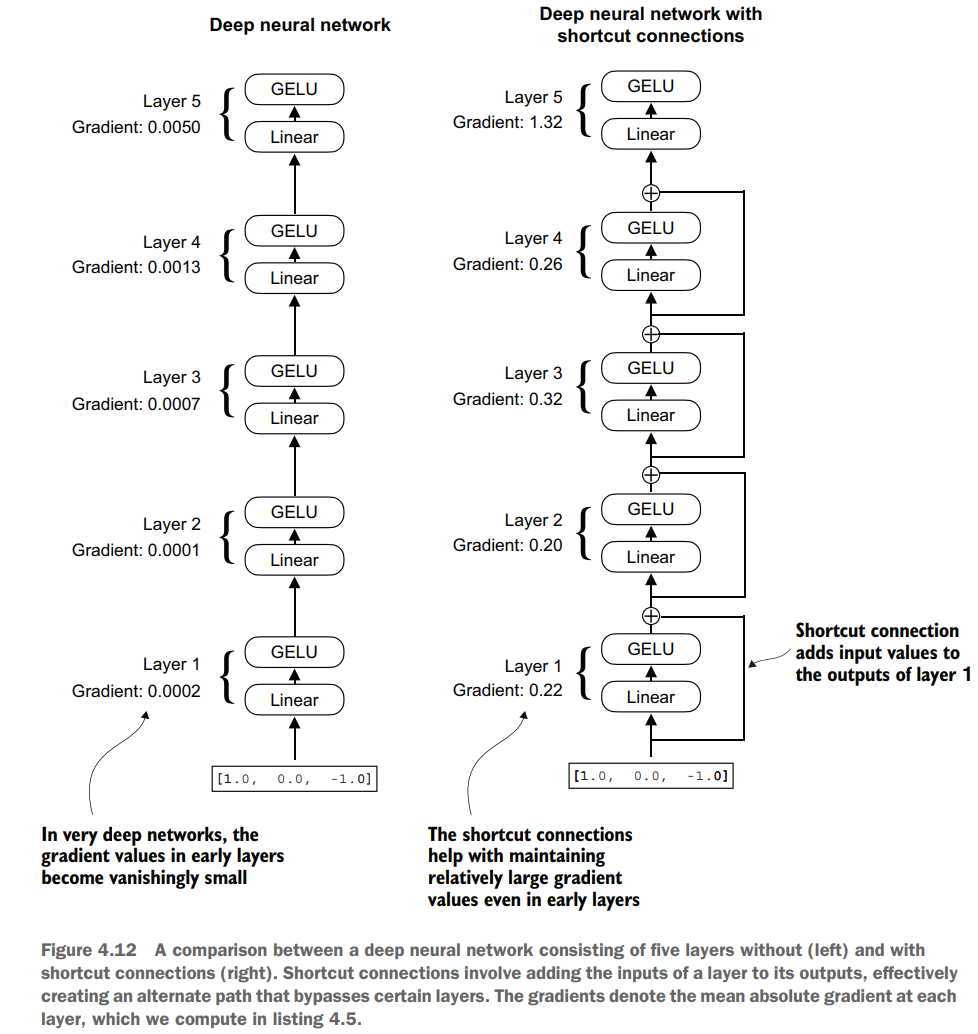

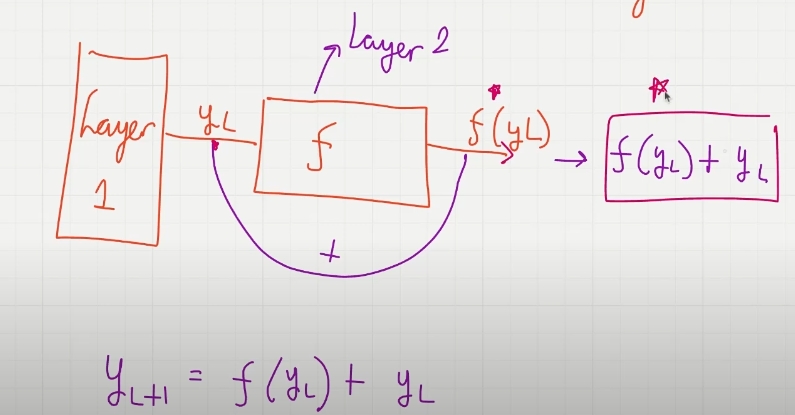
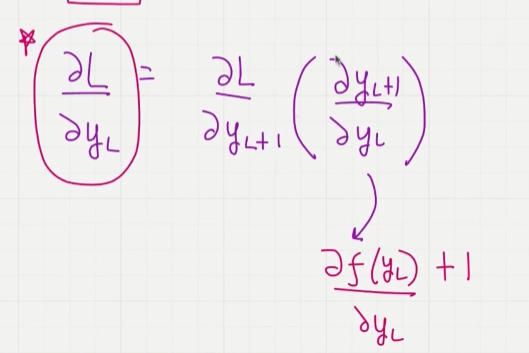
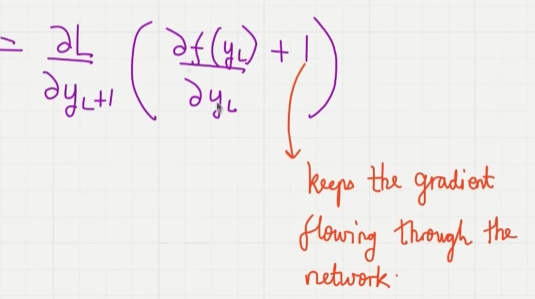

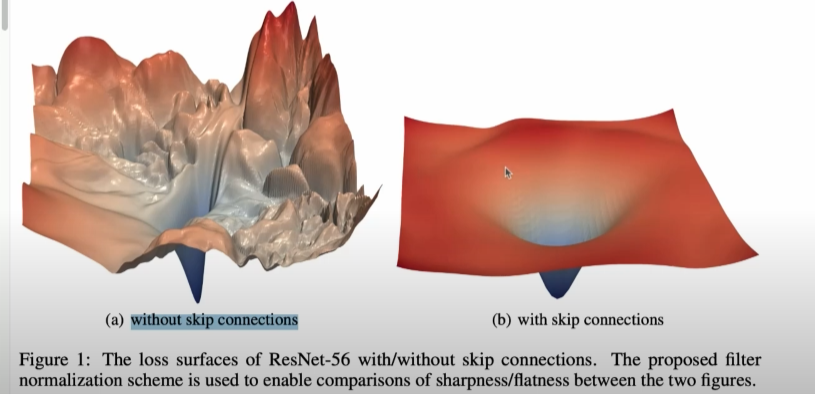

In [4]:
class GELU(nn.Module):
    def __init__(self):

        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

In [5]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([ 
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                            GELU())
        ])


    def forward(self, x):
        
        for layer in self.layers:
            layer_output = layer(x) 
            if self.use_shortcut and x.shape == layer_output.shape: 
                x = x + layer_output
            else:
                x = layer_output
        
        return x

Initializing model without skip connections

In [6]:
layer_sizes = [3, 3, 3, 3, 3, 1] 
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123) 

model_without_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=False
)

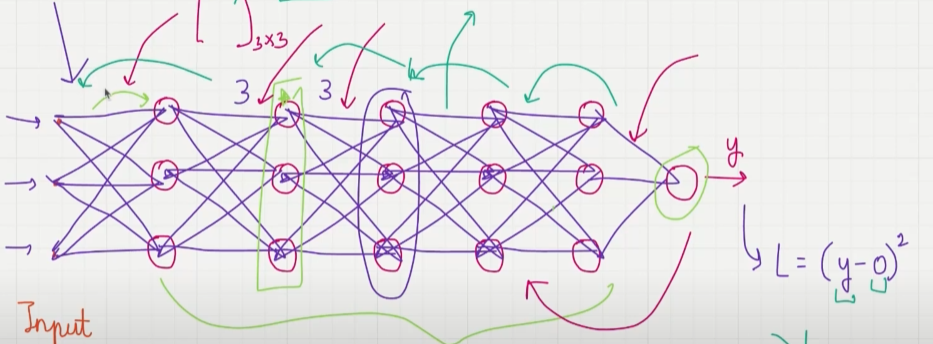

For the neural network we will implement a simple backward pass as follows and print the average of weights at each layer.

Except the output layer, all layers will have $3$ x $3$ weight matrices

In [13]:
def print_gradients(model, x):

    output = model(x) 
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target) 

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()} and shape = {param.shape}")

In [14]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0006052075768820941 and shape = torch.Size([3, 3])
layers.1.0.weight has gradient mean of 0.00036033481592312455 and shape = torch.Size([3, 3])
layers.2.0.weight has gradient mean of 0.002145612146705389 and shape = torch.Size([3, 3])
layers.3.0.weight has gradient mean of 0.00419662008062005 and shape = torch.Size([3, 3])
layers.4.0.weight has gradient mean of 0.01514893677085638 and shape = torch.Size([1, 3])


Initialize model with skip connections

In [10]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263
